## Importing libraries

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense,
    LSTM,
    Dropout,
    Lambda,
    Flatten,
    TimeDistributed
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.optimizers import Adam, SGD
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import moment

## Get train and test sets

In [74]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
train_set['date'] = pd.to_datetime(train_set['date'], format="%Y-%m-%d")

In [75]:
train_set.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## Insert the notion of weekdays  and days of month

In [76]:
train_set['year']    =  train_set['date'].dt.year
train_set['month']   =  train_set['date'].dt.month
train_set['day']     =  train_set['date'].dt.dayofyear
train_set['weekday'] =  train_set['date'].dt.weekday
train_set['weekend'] =  train_set['weekday'] > 4

## Verifing the correlation between weekendays and sales

6
0


Text(0, 0.5, 'Mean of sales value')

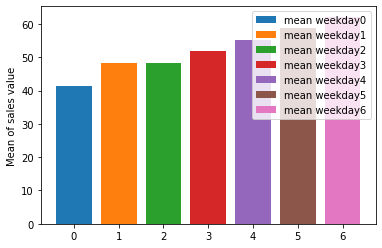

In [77]:
print(train_set['weekday'].max())
print(train_set['weekday'].min())

for value in range(train_set['weekday'].min(),train_set['weekday'].max() + 1):
    mean_weekday = train_set[(train_set['weekday'] == value)]['sales'].mean() 
    plt.bar([value],[mean_weekday], label=f'mean weekday{value}')

plt.legend()
plt.ylabel('Mean of sales value')

### This shows that the sales value increases in the weekends and decreces in the weekdays
This means that the weekdays could be valuable income data in a machine learning model, this is possible to know beforehand what the weekdays of the desirable prediction and this data presents a direct correlation between the value of the sales. Thus, the `weekdays` value could be a good entry feature of the model.

## Geting the series of one store and one item

In [78]:
item_set = train_set[(train_set['item'] == 1) & (train_set['store'] == 1)]

In [79]:
item_train_set = item_set[(item_set['date'] < "2016-12-31")]
item_test_set  = item_set[(item_set['date'] > "2016-12-31")]

In [80]:
item_train_set.head()

,date,store,item,sales,year,month,day,weekday,weekend
0,2013-01-01,1,1,13,2013,1,1,1,False
1,2013-01-02,1,1,11,2013,1,2,2,False
2,2013-01-03,1,1,14,2013,1,3,3,False
3,2013-01-04,1,1,13,2013,1,4,4,False
4,2013-01-05,1,1,10,2013,1,5,5,True


In [81]:
item_test_set.head()

,date,store,item,sales,year,month,day,weekday,weekend
1461,2017-01-01,1,1,19,2017,1,1,6,True
1462,2017-01-02,1,1,15,2017,1,2,0,False
1463,2017-01-03,1,1,10,2017,1,3,1,False
1464,2017-01-04,1,1,16,2017,1,4,2,False
1465,2017-01-05,1,1,14,2017,1,5,3,False


## The data behavior

One of the most important analyses of time series data is to detect if the subject series is stationary or not, if not further transformations are required to remove trend and seasonality of the series, this analysis is even more important using statistic based models. Many authors of papers that use neural networks (NN) for time series defend that using this kind of machine learning model does not necessarily require the data to be already stationary. Although, is important to know if the data is stationary even if the model selected is a NN, because if the model does not converges well this could be a cause and know the properties of the series is highly valuable as well.

[1] Define a weak stationary time series if the mean function $ E[x(t)] $ is independent of $ t $, if the autocoraviation function $Cov (x(t+h), x(t))$ is independent of $ t $ for each $h$ and if $E[x^2[n]]$ is finite for each $n$.

To perform the weak stationary test, the mean function and the autocovariation function ware applied over rolling windows, since its sampled data. Thus, the window size has an impact over the functions interpretations, the window represents the interval in which the stationary hypothesis is tested.

Besides this definition, the $ statsmodels $ library has the Augmented Dickey-Fuller unit root test. The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

References
[1] Brockwell, Peter J., and Richard A. Davis. Introduction to time series and forecasting. springer, 2016.

In [82]:
def stationary_test(entry,delta=200,ad=False,std=False):
    window_size=int(len(entry)/15)
    # Weak stationary test
    # Mean function
    mean_y = []
    mean_x = []
    
    s_moment_y = []
    std_y = []
    n_data = len(entry)
    for i in range(0, int(n_data - window_size)):
        # Roling window start and end
        n_start = i
        n_end = n_start + window_size
        # Mean, standard deviation and second moment calculation
        mean_y_i = np.mean(entry[n_start:n_end])
        s_moment_y_i = moment(entry[n_start:n_end],moment=2)
        std_y_i = np.std(entry[n_start:n_end])
        # Saving the results 
        mean_y.append(mean_y_i)
        mean_x.append(n_end)
        s_moment_y.append(s_moment_y_i)
        std_y.append(std_y_i)

    # Autocovariance function
    acov_y = []
    acov_x = []
    n_data = len(entry)
    for i in range(0, int(n_data - window_size - delta)):
        n_start = i
        n_end = n_start + window_size
        acov_y_i = np.cov(
            entry[n_start:n_end], entry[n_start+delta:n_end+delta]
        )[0][0]
        acov_y.append(acov_y_i)
        acov_x.append(n_end)
    if(ad):
        result = adfuller(entry)
        print("ADF Statistic: %f" % result[0])
        print("p-value: {0}".format(result[1]))
        print("Critical Values:")
        for key, value in result[4].items():
            print("\t%s: %.3f" % (key, value))
        # if the p-value < 0.05  and the adf statistic is less than
        # critical values the series is stationary or is time independent
        
    return [mean_x,mean_y],[acov_x,acov_y], s_moment_y, std_y

<AxesSubplot:xlabel='date'>

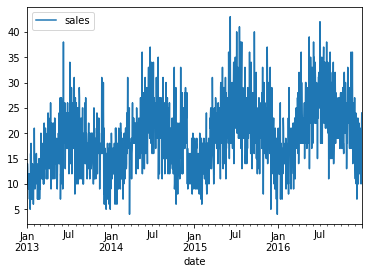

In [83]:
item_train_set.plot(x='date', y='sales')

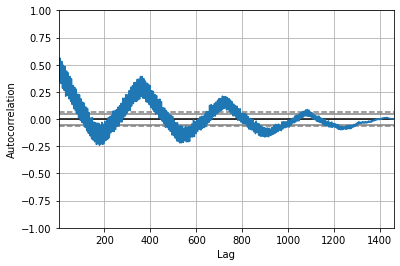

In [84]:
pd.plotting.autocorrelation_plot(item_train_set['sales'])
plt.show()

ADF Statistic: -2.819719
p-value: 0.055511749406477906
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


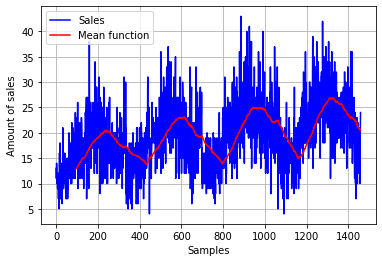

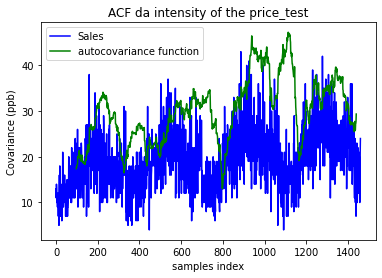

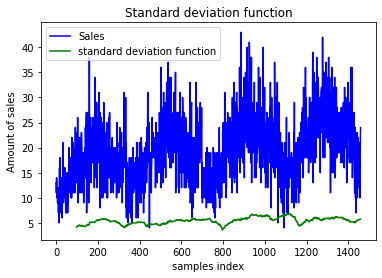

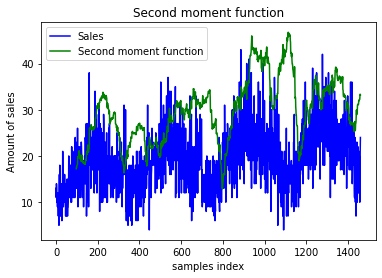

In [85]:
# Weak stationary test
sales_train = item_train_set['sales'].to_numpy()

mean, cov, s_moment, std = stationary_test(sales_train, delta=20,ad=True) 

plt.figure()
plt.subplot()
plt.plot(sales_train, "b", label="Sales")
plt.plot(mean[0], mean[1], "r", label="Mean function")
plt.xlabel("Samples")
plt.ylabel("Amount of sales")
plt.grid('on')
plt.legend()
plt.show()

plt.figure()
plt.plot(sales_train, "b", label="Sales")
plt.plot(cov[0], cov[1], "g", label="autocovariance function")
plt.xlabel("samples index")
plt.ylabel("Covariance (ppb)")
plt.title("ACF da intensity of the price_test")
plt.legend()
plt.show()

plt.figure()
plt.plot(sales_train, "b", label="Sales")
plt.plot(mean[0], std, "g", label="standard deviation function")
plt.xlabel("samples index")
plt.ylabel("Amount of sales")
plt.title("Standard deviation function")
plt.legend()
plt.show()

plt.figure()
plt.plot(sales_train, "b", label="Sales")
plt.plot(mean[0], s_moment, "g", label="Second moment function")
plt.xlabel("samples index")
plt.ylabel("Amount of sales")
plt.title("Second moment function")
plt.legend()
plt.show()

## Analyzing the test results
The mean function test hypothesis failed, this can be noted by checking the function follows the trend and seasonlity of the sales series, the covariation function presents a linear behavior with a lot of disturbance, the standard deviation function seans to be linear like, but with a lot of noise. The second-moment function doesn't show a tendency to infinite on any $n$, that way passing on this condition.

Analyzing the functions plots it's correct to infer that this series of sales is non-stationary, this can be also noted on the autocorrelation plot, which shows a slow decaying behavior.the autocorrelation plot shows also a periodic behavior, which represents a periodic behavior on the time series, and also in several lags the ACF value goes above and bellow the confidence intervals of 99% and 95%

Besides the week sationary test, theAugmented Dickey-Fuller test can be done to check if the series of sales is stationary or not. This test checks if the series have a unit root and doing so it can make the assumption of how much the series is defined by it's trend.

There are 2 Hypothesis:

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Since the p-value of the test value applied to the series is bigger than 0.05, the null hypothesis is rejected, thus the series is non-stationary


## Using Neural networks for solving the time series problem
First, it is necessary to transform this time series problem into a supervised learning problem; for this, it is necessary to define whether the network will make a recursive forecast, in which the forecasts will be used as resources for a longer time horizon or if the network will make a direct forecast, in which the network only uses the last steps of time and resources known as the day of the week, to forecast several steps.

### Direct prediction approach
To predict the 3 months of sales is necessary to define first the labels and features of the model, as features the model will use 3 months of past sales data and the 3 months of weekdays value. As labels would be 3 months of the future data, to extrat the labels and features of the data a rolling window approach is reaquired, this way a window of 3 months past data, 3 months of weekdays value could be related to 3 months of future data

## Rolling window approach

With this approach is possible to turn a series of data into a supervised learning problem, this way the model can intepretate the problem properly.

In [86]:
# Get the series of data needed and normalizing
weekday_train = item_train_set['weekday'].to_numpy()/item_train_set['weekday'].max()
sales_train   = item_train_set['sales'].to_numpy()
index_val     = np.arange(len(weekday_train))

# Three months of prediction
label_win = 90
feat_win  = 90
win_size  = label_win + feat_win 
n_windows = len(sales_train) - win_size

x_train = np.zeros((n_windows, int(2*feat_win)))
y_train = np.zeros((n_windows, label_win))
for win in range(n_windows):
    # Feature window start and end index
    i_s_feat = win
    i_e_feat = i_s_feat + feat_win
    
    # Label window start and end index
    i_s_label = i_e_feat
    i_e_label = i_s_label + label_win

    # Geting the past sales feature
    x_train[win][:feat_win] = sales_train[i_s_feat : i_e_feat] \
        / item_train_set['sales'].max()

    # Geting the weekdays feature
    x_train[win][feat_win:] = weekday_train[i_s_label : i_e_label]
    # Since we want the weekdays to be corralated to the label values
    # the window of weekdays value that we will use will be the label's
    # weekday. This makes sense taking in count that we know the weekdays
    # beforehand

    # Geting the labels
    y_train[win] = sales_train[i_s_label:i_e_label]


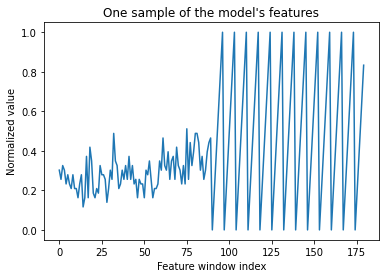

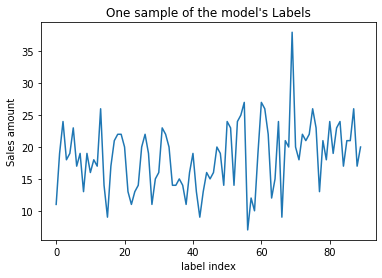

In [87]:
plt.plot(x_train[0], label='features')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of the model's features")
plt.show()

plt.plot(y_train[0], label='labels')
plt.ylabel('Sales amount')
plt.xlabel('label index')
plt.title("One sample of the model's Labels")
plt.show()


## Defining the model
The recommended neural network for a time series problem usualy is a LSTM, in this example peharps we will use a simple multi layer perceptron (MLP) model.

In [94]:
# Hyperparameters
h1 = 150
h2 = 150
activation_fcn = 'relu'
epochs = 200
batch = 64
lr = 0.001
lr_decay = lr / epochs
dp_percent = 0.2

optimizer = Adam(lr=lr, decay=lr_decay)
model = Sequential()
# Input layer
model.add(Dense(input_dim=x_train.shape[1], 
                units=h1, 
                activation=activation_fcn))
# Hidden layers
model.add(Dense(units=h2, activation=activation_fcn))
model.add(Dropout(dp_percent))
model.add(Dense(units=h2, activation=activation_fcn))
model.add(Dropout(dp_percent))
model.add(Dense(units=h2, activation=activation_fcn))
model.add(Dropout(dp_percent))
model.add(Dense(units=h2, activation=activation_fcn))

# Output layer
model.add(Dense(label_win, activation="linear"))
model.compile(loss='mse', optimizer=optimizer, metrics=["mae"])


## Training the model 

In [95]:
# Training the model
model.fit(
x_train,
y_train,
batch_size=batch,
epochs=epochs)

Epoch 1/200
20/20 [==============================] - 0s 2ms/step - loss: 291.2175 - mae: 14.9509
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 63.8256 - mae: 6.3397
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 52.2061 - mae: 5.7439
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 49.4274 - mae: 5.5954
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 46.9954 - mae: 5.4477
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 47.0903 - mae: 5.4466
Epoch 7/200
20/20 [==============================] - 0s 3ms/step - loss: 46.2685 - mae: 5.4029
Epoch 8/200
20/20 [==============================] - 0s 2ms/step - loss: 44.1498 - mae: 5.2768
Epoch 9/200
20/20 [==============================] - 0s 3ms/step - loss: 42.7136 - mae: 5.1892
Epoch 10/200
20/20 [==============================] - 0s 2ms/step - loss: 43.0843 - mae: 5.1970
Epoch 11/200
20/20 [===========================

## Testing

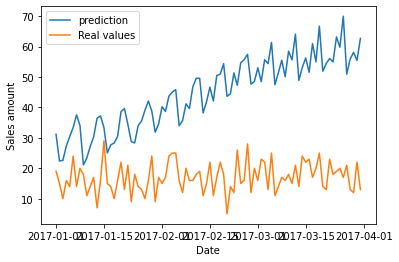

In [96]:
max_sales = item_train_set['sales'].max()
entry_test = np.zeros(int(2*feat_win))
entry_test[:feat_win] = item_train_set['sales'][-feat_win:].to_numpy() / max_sales 
entry_test[feat_win:] = item_test_set['weekday'][:feat_win].to_numpy()

label_test = item_test_set['sales'][:label_win].to_numpy()
dates = item_test_set['date'][:label_win].to_numpy()

prediction = model.predict(np.array([entry_test])).flatten()

plt.plot(dates,prediction, label='prediction')
plt.plot(dates,label_test, label='Real values')
plt.ylabel("Sales amount")
plt.xlabel("Date")
plt.legend()
plt.show()